# Model

In this notebook, the data extracted in *data_extraction* notebook will be used to try to predict the rating of a given player, given a specific game scenario (defined by the game stats up to the moment).

An analysis of feature importance will also be made.

In [377]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from collections import Counter

## Load data

In [417]:
with open('stats_df.pickle', 'rb') as handle:
    stats_df = pickle.load(handle)

stats_df.head()

,shots_before_norm,shots_goals_before,shots_opp_before_norm,passes_all_before_norm,passes_keys_before_norm,passes_crosses_before_norm,passes_assists_before,passes_opp_before_norm,freekicks_before,corners_before,...,save_attempts_before_norm,clearances_before_norm,shots_goals_against_before,min,other_team,player_name,player_role,home,diff_goals,rating
0,9.15,0,4.58,675.76,1.53,22.88,0,0.0,32,5,...,0.00,15.25,0,59,Southampton,G. Jesus,Forward,False,0,7.04
1,11.54,0,6.92,600.00,1.15,23.08,0,0.0,41,9,...,1.15,18.46,0,78,Southampton,B. Diaz,Midfielder,False,0,6.03
2,10.98,0,6.59,574.02,1.10,21.95,0,0.0,43,9,...,1.10,17.56,0,82,Southampton,P. Foden,Midfielder,False,0,6.12
3,18.95,3,14.21,819.47,4.74,18.95,3,0.0,30,4,...,7.11,22.50,1,76,Brighton & Hove Albion,B. Mendy,Defender,True,2,6.27
4,18.43,3,14.10,808.92,5.42,17.35,3,0.0,32,4,...,7.59,20.60,1,83,Brighton & Hove Albion,B. Diaz,Midfielder,True,2,6.09


## EDA

A set of specific analysis, with respect to particula features, is going to be performed

**Substitutions time**

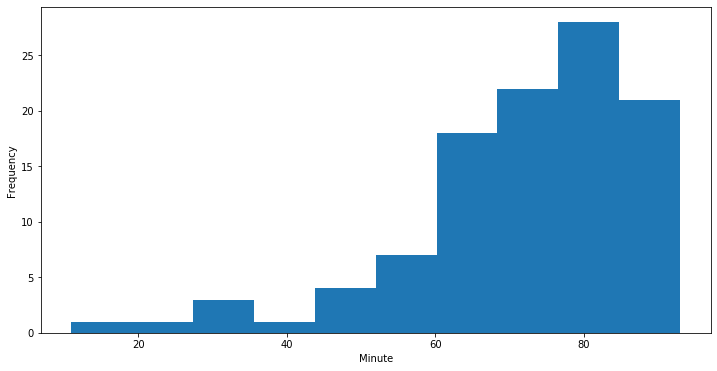

In [327]:
plt.figure(figsize=(12, 6))
plt.hist(pd.to_numeric(stats_df["min"]))
plt.xlabel('Minute')
plt.ylabel('Frequency')
plt.show()

Substitiuions are clearly more shifted towards the end of the game

**Moment of substitution vs current goal difference**

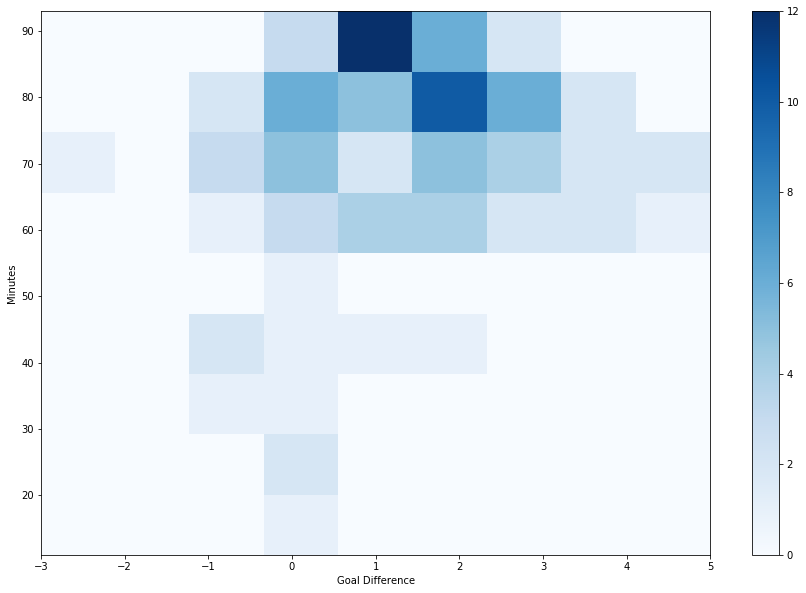

In [435]:
plt.figure(figsize=(15, 10))
plt.hist2d(stats_df['diff_goals'], stats_df['min'], bins=9, cmap="Blues")
plt.colorbar()
plt.xlabel('Goal Difference')
plt.ylabel('Minutes')
plt.show()

Moment of substitution tends to be closer to the end of the game, without any significant correlation with the goals difference.

**Need of substitutions to change the game**

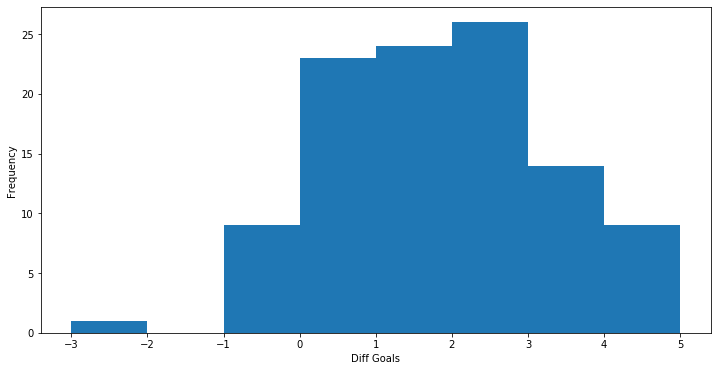

Number of games winning at subs time:  0.6886792452830188


In [332]:
plt.figure(figsize=(12, 6))
plt.hist(pd.to_numeric(stats_df["diff_goals"]), 8)
#stats_df['diff_goals'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel('Diff Goals')
plt.ylabel('Frequency')
plt.show()

print("Number of games winning at substitution time: ", sum(stats_df['diff_goals']>0)/len(stats_df))

The majority of the substitutions were made when the team was winning, which proves the team superiority in this season.

This means that, the team realy did not depended on substitutions to solve a solve a game, as normally there were already with the advantage on the scoreline

**Types of substitutions (type of player vs goals diff)**

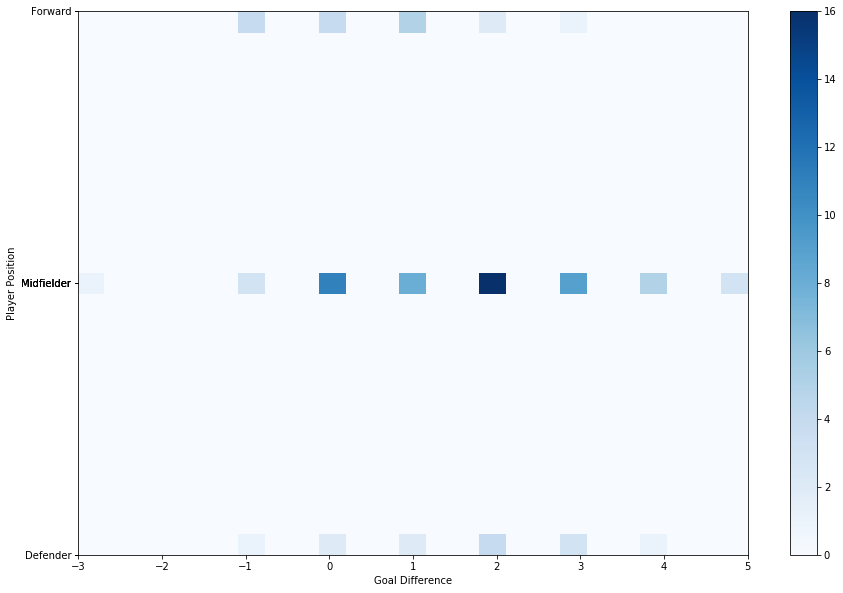

In [399]:
stats_df = stats_df[(stats_df['min'] > 45) & (stats_df['min'] < 87)]


def label_func(x):
    if x == 'Goalkeeper':
        return 0
    elif x == 'Defender':
        return 1
    elif x == 'Midfielder':
        return 2
    else:
        return 3

p_role = stats_df['player_role'].apply(label_func)
diff_goals = stats_df['diff_goals']

#plt.scatter(diff_goals, p_role)
#plt.show()

plt.figure(figsize=(15, 10))
plt.hist2d(stats_df['diff_goals'], p_role, bins=25, cmap="Blues")
plt.colorbar()
plt.yticks(p_role, stats_df['player_role'][:5])
plt.xlabel('Goal Difference')
plt.ylabel('Player Position')
plt.show()

We can see that midfielders are the ones replaced more frequently, independently of the game score. Contrary to what is the general belief, there was not a clear idea to put defender when the team is winning and put forwards when team is losing.
As demonstrated below, the players that enter the game are generally the same.

In [427]:
stats_df[(stats_df['diff_goals'] <= 0)].groupby(['player_name']).size().sort_values()[::-1]

player_name
G. Jesus       5
B. Silva       5
D. Danilo      4
S. Aguero      3
I. Gundogan    3
R. Sterling    2
L. Sane        2
Y. Toure       1
P. Foden       1
N. Otamendi    1
K. Bruyne      1
J. Stones      1
E. Mangala     1
D. Silva       1
B. Mendy       1
B. Diaz        1
dtype: int64

In [434]:
stats_df[(stats_df['diff_goals'] == 1) & (stats_df['min'] > 85)].groupby(['player_name']).size().sort_values()[::-1]

player_name
B. Silva       4
Y. Toure       1
P. Foden       1
I. Gundogan    1
E. Mangala     1
D. Danilo      1
B. Diaz        1
dtype: int64

**Rating distribution**

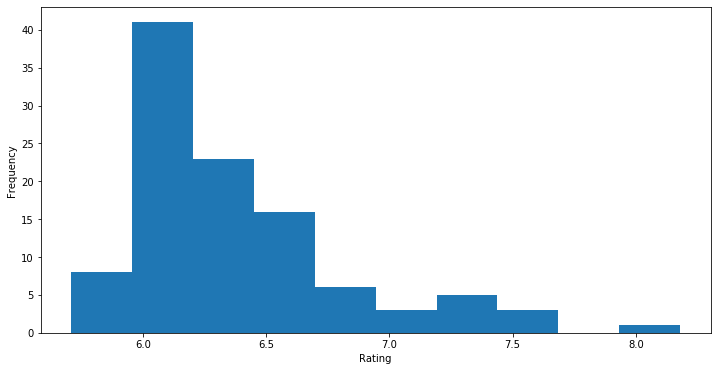

In [436]:
plt.figure(figsize=(12, 6))
plt.hist(pd.to_numeric(stats_df["rating"]), 10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

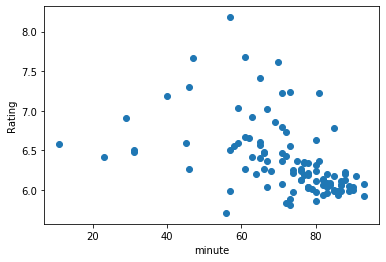

In [439]:
plt.scatter(stats_df['min'], pd.to_numeric(stats_df["rating"]))
plt.xlabel('minute')
plt.ylabel('Rating')
plt.show()

Ratings closer to 6 are related to substitutions closer to the end of the game.

This clearly shows that the rating of 6 corresponds to a baseline, and depending on the player performance during the time he was on the pitch, it could go down or up

In [200]:
# missing values

stats_df.isna().sum().sum()

0

**Stats distribution**

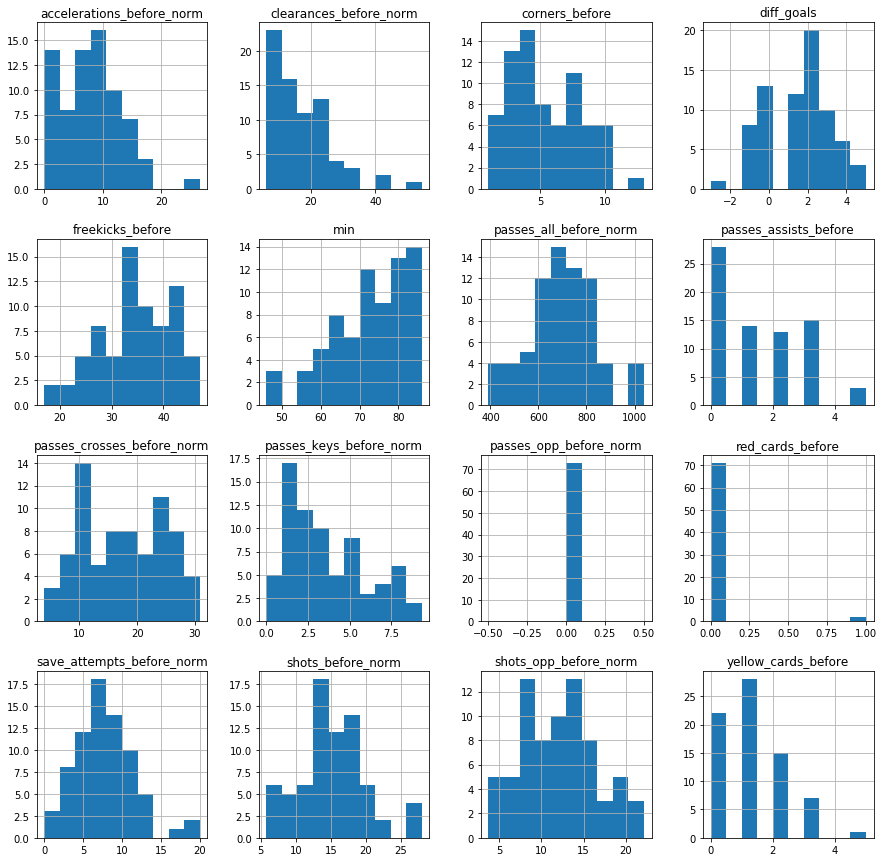

In [461]:
from pandas.plotting import scatter_matrix

X_train.iloc[:, :16].hist(figsize=(15, 15))
plt.show()

## Data Split

In [400]:
X = stats_df.drop(['rating'], axis=1)
y = stats_df['rating'].values


group_split = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in group_split.split(X, y, stats_df['other_team']):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

**Feature Engineering**

In [401]:
X_train.drop(['home', 'other_team', 'shots_goals_before', 'shots_goals_against_before'], axis=1, inplace=True)
X_test.drop(['home', 'other_team', 'shots_goals_before', 'shots_goals_against_before'], axis=1, inplace=True)


/Users/danielazevedo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [402]:
X_train

,shots_before_norm,shots_opp_before_norm,passes_all_before_norm,passes_keys_before_norm,passes_crosses_before_norm,passes_assists_before,passes_opp_before_norm,freekicks_before,corners_before,accelerations_before_norm,yellow_cards_before,red_cards_before,save_attempts_before_norm,clearances_before_norm,min,player_name,player_role,diff_goals
0,9.15,4.58,675.76,1.53,22.88,0,0.0,32,5,9.15,0,0,0.00,15.25,59,G. Jesus,Forward,0
1,11.54,6.92,600.00,1.15,23.08,0,0.0,41,9,9.23,1,0,1.15,18.46,78,B. Diaz,Midfielder,0
2,10.98,6.59,574.02,1.10,21.95,0,0.0,43,9,8.78,1,0,1.10,17.56,82,P. Foden,Midfielder,0
3,18.95,14.21,819.47,4.74,18.95,3,0.0,30,4,4.74,1,0,7.11,22.50,76,B. Mendy,Defender,2
4,18.43,14.10,808.92,5.42,17.35,3,0.0,32,4,4.34,1,0,7.59,20.60,83,B. Diaz,Midfielder,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,16.62,12.46,481.85,5.54,9.69,0,0.0,42,5,5.54,2,0,6.92,19.38,65,D. Danilo,Defender,-1
69,15.65,11.74,487.83,5.22,9.13,0,0.0,46,5,6.52,2,0,6.52,19.57,69,B. Silva,Midfielder,-1
70,14.56,9.26,716.03,3.97,25.15,0,0.0,31,8,9.26,0,0,3.97,30.44,68,L. Sane,Midfielder,0
71,13.85,9.23,693.46,3.46,23.08,1,0.0,37,9,9.23,0,0,5.77,27.69,78,R. Sterling,Forward,1


**Feature Categorization**

In [405]:

categorical_cols = ['player_role', 'player_name']

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[categorical_cols].values)

categorical_features_train = pd.DataFrame(enc.transform(X_train[categorical_cols].values).toarray())
categorical_features_test = pd.DataFrame(enc.transform(X_test[categorical_cols].values).toarray())

# rename columns
categorical_features_train.columns = enc.get_feature_names(['pos', 'player'])
categorical_features_test.columns = enc.get_feature_names(['pos', 'player'])

# data
X_train = pd.concat([X_train, categorical_features_train], axis=1).drop(categorical_cols, axis=1)
X_test = pd.concat([X_test, categorical_features_test], axis=1).drop(categorical_cols, axis=1)

In [406]:
X_train.head()

,shots_before_norm,shots_opp_before_norm,passes_all_before_norm,passes_keys_before_norm,passes_crosses_before_norm,passes_assists_before,passes_opp_before_norm,freekicks_before,corners_before,accelerations_before_norm,...,player_J. Stones,player_K. Bruyne,player_L. Nmecha,player_L. Sane,player_N. Otamendi,player_O. Zinchenko,player_P. Foden,player_R. Sterling,player_S. Aguero,player_Y. Toure
0,9.15,4.58,675.76,1.53,22.88,0,0.0,32,5,9.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.54,6.92,600.00,1.15,23.08,0,0.0,41,9,9.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.98,6.59,574.02,1.10,21.95,0,0.0,43,9,8.78,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,18.95,14.21,819.47,4.74,18.95,3,0.0,30,4,4.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.43,14.10,808.92,5.42,17.35,3,0.0,32,4,4.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Feature Reduction**

In [464]:

pca = PCA(n_components=3)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum()[-1])

[0.98218139 0.00663424 0.00495564]
0.9937712667054653


By analysing the variance explained by PCA, we can conclude that the 3 dimensions can be a good representation of the original features

**Model**

In [408]:
# Model

model = SVR()
model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)

In [409]:
mean_squared_error(y_test, y_pred, squared=True)

0.3353925013782244

By analysing the RMSE, we can see that, in average, the model fails to predict the correct score by a margin of 0.33.
This seems to be an interesting result, however, as we concluded before, normally, the substitutions did not bring much value/impact on the teams game (they had it already under control). Thus, the ratings (as we also saw) are around 6, which is why the results will be reasonable (as there were not much outstanders/outliers)

The lack of data representativity (team bias) and amount of data also made, probably, the model overfit. Therefore, the use of more data shoud be helpfull to validate the results obtained.

In [413]:
# example on the application of the model, for a given game scenario

example_df = X.iloc[test_index, :].iloc[[-3], :].copy()

example_df = example_df.append([example_df]*4,ignore_index=True)

example_df[['player_name', 'player_role']] = [
    ['R. Sterling', 'Forward'],
    ['E. Mangala', 'Defender'],
    ['L. Sane', 'Midfielder'],
    ['S. Aguero', 'Forward'],
    ['F. Delph', 'Midfielder']
]

# process and predict
example_df.drop(['home', 'other_team', 'shots_goals_before', 'shots_goals_against_before'], axis=1, inplace=True)

categorical_features_ex = pd.DataFrame(enc.transform(example_df[categorical_cols].values).toarray())
example_df = pd.concat([example_df, categorical_features_ex], axis=1).drop(categorical_cols, axis=1)

example_df_reduced = pca.transform(example_df)

model.predict(example_df_reduced)

array([6.32102451, 6.32099113, 6.32074973, 6.32098205, 6.32073225])

## Feature Importance

In [415]:
model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_
inds = importance.argsort()[::-1]

cols = X_train.columns.values[inds]
for i,v in enumerate(importance[inds]):
    print('Feature %s:, Score: %.5f' % (cols[i],v))

Feature player_K. Bruyne:, Score: 0.43760
Feature red_cards_before:, Score: 0.37185
Feature player_L. Sane:, Score: 0.30011
Feature player_J. Stones:, Score: 0.25622
Feature player_R. Sterling:, Score: 0.23588
Feature player_O. Zinchenko:, Score: 0.22806
Feature player_S. Aguero:, Score: 0.11011
Feature pos_Midfielder:, Score: 0.06691
Feature shots_opp_before_norm:, Score: 0.06142
Feature player_B. Silva:, Score: 0.05881
Feature pos_Forward:, Score: 0.05129
Feature player_B. Mendy:, Score: 0.02929
Feature freekicks_before:, Score: 0.01455
Feature passes_assists_before:, Score: 0.01423
Feature save_attempts_before_norm:, Score: 0.00926
Feature passes_all_before_norm:, Score: 0.00075
Feature corners_before:, Score: 0.00014
Feature passes_opp_before_norm:, Score: 0.00000
Feature player_P. Foden:, Score: -0.00009
Feature passes_crosses_before_norm:, Score: -0.00323
Feature clearances_before_norm:, Score: -0.00868
Feature player_B. Diaz:, Score: -0.00970
Feature accelerations_before_norm:, 


By analysing the feature importance using a Linear Regression, we can clearly see that the number of red cards and some players have a greater tendency in having a positive score (which means they help the team). This indeed makes sense, as, for example, De Bruyne was considered the best playmaker, and the second one was Sané. Aguero was also one of the top scorers.